In [ ]:
!pip install datasets


  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
Using cached dill-0.3.8-py3-none-any.whl (116 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 51.4 MB/s eta 0:00:00a 0:00:01


In [ ]:
from datasets import load_dataset

ds2 = load_dataset("laion/clevr-webdataset")

/home/vijay/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating train split: 699989 examples [01:02, 11116.45 examples/s]
Generating validation split: 149991 examples [00:13, 11084.31 examples/s]
Generating test split: 149988 examples [00:13, 11101.68 examples/s]


In [ ]:
# Function to process the txt column and split it into question and answer
def process_txt_column(example):
    if "txt" in example and isinstance(example["txt"], str):
        # Split the text into question and answer
        parts = example["txt"].split('?')
        question = parts[0] + '?' if len(parts) > 0 else ''
        answer = parts[1].strip() if len(parts) > 1 else ''
        # Return only the required fields
        return {
            "jpg": example["jpg"],
            "question": question,
            "answer": answer
        }
    return example

# Apply processing to the dataset
processed_ds = ds2.map(process_txt_column, remove_columns=[col for col in ds2["train"].column_names if col not in ["jpg", "txt"]])

# Convert to a Pandas DataFrame for better visualization (optional)
processed_df = processed_ds["train"].to_pandas()

# View the processed data
print(processed_df.head())


Map: 100%|██████████| 149988/149988 [07:56<00:00, 314.92 examples/s]


                                                 jpg  \
0  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   
1  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   
2  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   
3  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   
4  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...   

                                                 txt  \
0  Are there more big green things than large pur...   
1  How many other things are there of the same sh...   
2  Is the color of the large sphere the same as t...   
3  What material is the big object that is right ...   
4            How big is the brown shiny sphere?large   

                                            question  answer  
0  Are there more big green things than large pur...     yes  
1  How many other things are there of the same sh...       2  
2  Is the color of the large sphere the same as t...      no  
3  What material is the big object that is right ...  rubber  
4          

In [ ]:
del ds2


In [ ]:
# # Save the DataFrame to a CSV file
# processed_df.to_csv("processed_data.csv", index=False)

# # In Google Colab, you can use the following to create a download link
# from google.colab import files
# files.download("processed_data.csv")


In [ ]:
import torch
from datasets import load_dataset
from transformers import BlipProcessor, BlipForQuestionAnswering
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import Dataset
from tqdm import tqdm


In [ ]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()  # This keeps the image values in the range [0, 1]
])


In [ ]:
import random
from torch.utils.data import Dataset

class Visual7WDataset(Dataset):
    def __init__(self, dataset, transform=None, num_samples=10000):
        self.dataset = dataset
        self.transform = transform

        # Randomly sample 'num_samples' data from the dataset
        self.num_samples = num_samples
        self.sampled_data = random.sample(range(len(self.dataset['train'])), num_samples)

    def __len__(self):
        return self.num_samples  # Return the number of samples you want

    def __getitem__(self, idx):
        # Use the sampled indices to get the data
        item = self.dataset['train'][self.sampled_data[idx]]  # 'train' or 'test' depending on your phase

        image = item['jpg']  # Assuming the image column in the dataset
        question = item['question']
        answer = item['answer']

        # Apply the transformation to the image
        if self.transform:
            image = self.transform(image)

        return image, question, answer

In [ ]:
# Initialize the dataset and DataLoader
train_dataset = Visual7WDataset(processed_ds, transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [ ]:
import zipfile
import os

# Specify the path to the zip file
zip_file_path = '/content/blip_How_many.zip'  # Replace with the actual path to your zip file

# Specify the directory where you want to unzip the folder
unzip_dir = 'blip'  # Path to unzip the model

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)
from transformers import BlipProcessor, BlipForQuestionAnswering

# Load the model and processor
model = BlipForQuestionAnswering.from_pretrained(unzip_dir)
processor = BlipProcessor.from_pretrained(unzip_dir)

In [ ]:
# # Load the BLIP processor and model
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")


/home/vijay/miniconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Move model to the appropriate device
model = model.to(device)


In [ ]:
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=5e-5)
from transformers import get_scheduler

num_training_steps = len(train_loader) * 3  # 3 epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

In [ ]:
for epoch in range(3):  # Number of epochs
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=True)

    for images, questions, answers in loop:
        images = images.to(device)

        # Process inputs and tokenize answers
        inputs = processor(images=images, text=questions, return_tensors="pt", padding=True)
        labels = processor.tokenizer(answers, padding=True, truncation=True, return_tensors="pt").input_ids
        inputs = {key: value.to(device) for key, value in inputs.items()}
        labels = labels.to(device)

        # Forward pass and loss computation
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss

        # Backward pass and optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()  # Optional scheduler step

        # Print the loss every step
        loop.set_postfix(loss=loss.item())


Epoch 3: 100%|██████████| 1250/1250 [17:09<00:00,  1.21it/s, loss=0.358]


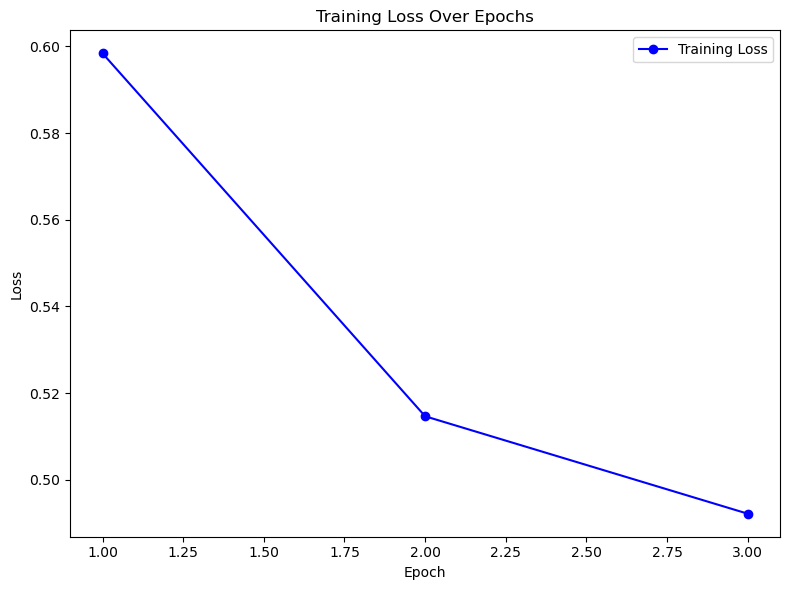

In [ ]:
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

# List to track loss for each epoch
epoch_losses = []

# Train the model for 3 epochs
for epoch in range(3):  # Number of epochs
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=True)

    # Variable to track total loss for this epoch
    total_loss = 0

    for images, questions, answers in loop:
        images = images.to(device)

        # Process inputs and tokenize answers
        inputs = processor(images=images, text=questions, return_tensors="pt", padding=True)
        labels = processor.tokenizer(answers, padding=True, truncation=True, return_tensors="pt").input_ids
        inputs = {key: value.to(device) for key, value in inputs.items()}
        labels = labels.to(device)

        # Forward pass and loss computation
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss

        # Backward pass and optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()  # Optional scheduler step

        # Track total loss for this epoch
        total_loss += loss.item()

        # Print the loss every step
        loop.set_postfix(loss=loss.item())

    # Calculate average loss for the epoch
    avg_loss = total_loss / len(loop)

    # Append average loss for this epoch to the list
    epoch_losses.append(avg_loss)

# Plotting loss graph after all epochs
plt.figure(figsize=(8, 6))
plt.plot(range(1, 4), epoch_losses, marker='o', color='b', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Show the graph
plt.tight_layout()
plt.show()


In [ ]:
model_save_path = "/home/vijay/Desktop/nlp/blip_clevr"
model.save_pretrained(model_save_path)

# Save the processor (tokenizer and feature extractor)
processor_save_path = "/home/vijay/Desktop/nlp/blip_clevr"
processor.save_pretrained(processor_save_path)

print("BLIP model and processor saved successfully.")

BLIP model and processor saved successfully.


#TESTING

In [ ]:
import random
from torch.utils.data import Dataset

class Visual7WDataset(Dataset):
    def __init__(self, dataset, transform=None, num_samples=1000):
        self.dataset = dataset
        self.transform = transform

        # Randomly sample 'num_samples' data from the dataset
        self.num_samples = num_samples
        self.sampled_data = random.sample(range(len(self.dataset['validation'])), num_samples)

    def __len__(self):
        return self.num_samples  # Return the number of samples you want

    def __getitem__(self, idx):
        # Use the sampled indices to get the data
        item = self.dataset['validation'][self.sampled_data[idx]]  # 'train' or 'test' depending on your phase

        image = item['jpg']  # Assuming the image column in the dataset
        question = item['question']
        answer = item['answer']

        # Apply the transformation to the image
        if self.transform:
            image = self.transform(image)

        return image, question, answer

In [ ]:
test_dataset = Visual7WDataset(processed_ds, transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
for images, questions, answers in test_loader:
    print(questions)
    print(images)

In [ ]:
from sklearn.metrics import accuracy_score

def calculate_accuracy(data_loader):
    all_predictions = []
    all_true_answers = []

    # Iterate through the dataset
    for images, questions, answers in data_loader:
        for i in range(8):
            image = images[i].to(device)

            # Process inputs and tokenize answers
            inputs = processor(images=image, text=questions[i], return_tensors="pt", padding=True)
            inputs = {key: value.to(device) for key, value in inputs.items()}

            # Inference (generate the answer)
            with torch.no_grad():
                generated_ids = model.generate(**inputs)

            # Decode the generated answer
            predicted_answer = processor.decode(generated_ids[0], skip_special_tokens=True)

            # Collect predictions and true answers
            all_predictions.append(predicted_answer.strip())  # Strip leading/trailing spaces
            all_true_answers.append(answers[i])  # Strip leading/trailing spaces

    # Manually compute accuracy by comparing exact matches
    correct_predictions = sum([1 if pred == true else 0 for pred, true in zip(all_predictions, all_true_answers)])
    accuracy = correct_predictions / len(all_true_answers)  # Percentage of correct predictions

    print(all_predictions)
    print(all_true_answers)
    return accuracy
# Example usage
# Assuming you have a data loader for your validation or test set
accuracy = calculate_accuracy(test_loader)
print(f"Accuracy: {accuracy:.4f}")


/home/vijay/miniconda3/lib/python3.12/site-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['green', 'cylinder', '2', 'cylinder', 'no', 'yes', 'large', '1', '1', 'yes', 'green', 'no', '1', 'large', 'cylinder', 'green', '0', 'yes', 'no', 'metal', 'yes', 'no', 'no', 'no', 'yes', 'cylinder', '2', 'metal', 'cylinder', 'yes', 'no', 'red', 'metal', '2', 'green', 'yes', 'large', 'cylinder', 'yes', 'large', 'metal', 'no', '2', 'large', 'large', 'cylinder', 'metal', 'no', 'cylinder', 'yes', '2', 'no', 'metal', 'green', 'cylinder', '0', 'no', '2', 'yes', 'no', 'cylinder', 'red', 'metal', 'metal', '0', '0', '0', 'yes', '2', 'green', 'metal', 'cylinder', 'cylinder', 'cylinder', 'green', 'metal', 'no', 'no', 'small', 'no', '0', 'cylinder', '2', '0', 'metal', 'yes', '1', 'no', '0', 'yes', 'yes', 'metal', '1', '0', '0', '0', 'yes', 'red', 'yes', 'red', '0', 'no', 'no', 'yes', 'no', 'yes', 'large', '1', 'green', 'no', 'metal', 'small', 'red', '1', '4', 'yes', '2', 'yes', 'red', '1', 'metal', 'yes', 'yes', 'yes', 'green', 'green', 'yes', 'metal', 'cylinder', 'large', 'metal', 'cylinder', 'me

#INFERENCE

In [ ]:
from PIL import Image
import torch

def infer(image_path, question):
    # Load the image
    image = Image.open(image_path).convert("RGB")

    # Preprocess the image and question
    inputs = processor(images=image, text=question, return_tensors="pt", padding=True)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Inference (generate the answer)
    with torch.no_grad():
        generated_ids = model.generate(**inputs)

    # Decode the generated answer
    predicted_answer = processor.decode(generated_ids[0], skip_special_tokens=True)

    return predicted_answer

# Example usage
image_path = "/home/vijay/Desktop/nlp/image.jpg"
question = "How many other things are there of the same shape as the tiny cyan matte object?"
predicted_answer = infer(image_path, question)
print(predicted_answer)


2


**HEAT MAP GENERATION**

In [ ]:
from transformers import BlipForQuestionAnswering, BlipProcessor

# Load model and processor
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")

# Enable output of attentions
model.config.output_attentions = True


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]